# Initial EDA on Raw UNGA dataset

Data set is taken from here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/12379

In [42]:
# Import all the libraries used in the notebook
import pandas as pd
from matplotlib import pyplot as plt
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import scale
%matplotlib inline
import hdbscan
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint

In [229]:
# read tab file of voting records (1948 - 2017)
df_votes = pd.read_csv('~/Desktop/dataverse_files/UNVotes1-72.tab',sep='\t')

In [230]:
df_votes.shape

(1099156, 8)

In [44]:
# filter df for only voting members
df_votes = df_votes[df_votes.member == 1]

In [45]:
# Confirming that member column only reads "1" for voting members
df_votes.head(4)

,rcid,ccode,session,member,vote,Country,Countryname,year
0,3.0,2,1.0,1.0,1,USA,United States of America,1946
1,3.0,20,1.0,1.0,3,CAN,Canada,1946
3,3.0,40,1.0,1.0,1,CUB,Cuba,1946
4,3.0,41,1.0,1.0,1,HTI,Haiti,1946


In [46]:
# Dropping country and countryname. Using ccode as country key
df_votes_year = df_votes.drop(['Country', 'Countryname'], axis=1) 

In [47]:
# Set a DF to only yes and no votes (0 nd 3)
df_votes_year_binary = df_votes_year[(df_votes_year.vote <= 1) | (df_votes_year.vote == 3)]
df_votes_year_binary.head(2)

,rcid,ccode,session,member,vote,year
0,3.0,2,1.0,1.0,1,1946
1,3.0,20,1.0,1.0,3,1946


In [48]:
# Turn 1 = yes and 3 = no into 0 = no and 1 = yes
df_votes_year_binary.vote = df_votes_year_binary.vote.replace(to_replace=3, value=0, inplace=False, limit=None, regex=False, method='pad', axis=None)
df_votes_year_binary.head(2)


/Users/jakerattner/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,rcid,ccode,session,member,vote,year
0,3.0,2,1.0,1.0,1,1946
1,3.0,20,1.0,1.0,0,1946


In [49]:
# drop session column and set equal to new df
df_year_features = df_votes_year_binary.drop(['session'], axis=1)

In [50]:
df_year_features.head(4)

,rcid,ccode,member,vote,year
0,3.0,2,1.0,1,1946
1,3.0,20,1.0,0,1946
3,3.0,40,1.0,1,1946
4,3.0,41,1.0,1,1946


In [51]:
# Vote multiplied by res to create a new v_res column that gives the resolution number if 
# There was a yes vote.  This will be used later to create dummy columns
df_year_features['v_res'] = df_year_features['rcid']*df_year_features['vote']

In [52]:
#I'm creating a df that has one record for every UN nation so that it can be merged with our output later
df_name_index = pd.DataFrame(df_votes.groupby(['ccode', 'Countryname','Country'])['Countryname'].count())
df_name_index['count'] = df_name_index.Countryname
df_name_index = df_name_index.drop([ 'Countryname','count'], axis=1)
df_name_index.reset_index(inplace=True)
df_name_index.head(2)

,ccode,Countryname,Country
0,2,United States of America,USA
1,20,Canada,CAN


# Create function to create DFs for multiple years

In [53]:
# This function takes a year as an argument and returns a df with 1s and 0s indicating whether each member country
# voted on each resolution proposed in a that year
def create_year_df(year):
    df_output_year = df_year_features[df_year_features['year'] == year]
    df_output_year = pd.concat([df_output_year,pd.get_dummies(df_output_year.v_res, prefix='res_')], axis = 1)
    #print(df_output_year)
    try:
        df_output_year = df_output_year.drop(['year','rcid','member','v_res','vote', 'res__0.0'], axis=1)
    except:
        pass 
    df_output_year = df_output_year.set_index('ccode')
    df_output_year = df_output_year.groupby('ccode').sum()
    
    return df_output_year
create_year_df(1948);

In [54]:
# creating dictionary of years and corresponding dataframe names passing aech value from the 
# groups list into the for loop at the bottom of the cell
frames = {}
groups = [1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,  
          1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
          1975, 1976, 1977, 1978, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1986, 1988, 1989,
          1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
          2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
for grp in groups: 
    frames[grp] = create_year_df(grp)  

In [55]:
# Making sure my keys correspond with the groups list created in the last cell
frames.keys()

dict_keys([1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [56]:
# Confirming that the dataframe looks proper
frames.get(1946).head(4)

,res__3.0,res__4.0,res__5.0,res__6.0,res__7.0,res__8.0,res__9.0,res__10.0,res__11.0,res__12.0,...,res__36.0,res__37.0,res__38.0,res__39.0,res__40.0,res__41.0,res__42.0,res__43.0,res__44.0,res__45.0
ccode,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0,0,1,1,1
20,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,0
40,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,1,1,0
41,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0


In [57]:
# read in descr file
df_descriptions = pd.read_csv('~/documents/UN-Capstone/Dscription.csv',skipinitialspace=True)

In [58]:
# Looking at contents of the descr file
df_descriptions.head(2)

,Unnamed: 0,session,rcid,abstain,yes,no,importantvote,date,unres,amend,para,short,descr,me,nu,di,hr,co,ec,year
0,1,1,3,4,29,18,0,1946-01-01,R/1/66,1.0,0.0,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL REFERRING THE PROVISIONAL RULES OF PROCEDURE AND ANY AMENDME...,0,0,0,0,0,0,1946
1,2,1,4,8,9,34,0,1946-01-02,R/1/79,0.0,0.0,SECURITY COUNCIL ELECTIONS,TO ADOPT A USSR PROPOSAL ADJOURNING DEBATE ON AND POSTPONINGELECTIONS OF THE NON-PERMANENT MEMBERS OF THE ...,0,0,0,0,0,0,1946


In [59]:
df_descriptions['descr'].str.strip()

0       TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL REFERRING THE PROVISIONAL RULES OF PROCEDURE AND ANY AMENDME...
1       TO ADOPT A USSR PROPOSAL ADJOURNING DEBATE ON AND POSTPONINGELECTIONS OF THE NON-PERMANENT MEMBERS OF THE ...
2       TO ADOPT THE KOREAN PROPOSAL THAT INVALID BALLOTS BE INCLUDED IN THE TOTAL NUMBER OF \MEMBERS PRESENT AND ...
3          TO ADOPT A CUBAN PROPOSAL (A/3-C) THAT AN ITEM ON A DECLARATION OF THE RIGHTS AND DUTIES OF MAN BE TABLED.
4       TO ADOPT A 6TH COMMITTEE AMENDMENT (A/14) TO THE PROVISIONAL RULES OF PROCEDURE, WHICH AMENDMENT PROVIDES ...
5       TO ADOPT A SECOND 6TH COMM. AMENDMENT (A/14) TO THE PROVISIONAL RULES OF PROCEDURE, WHICH AMENDMENT EPLACE...
6       TO OPEN THE DISCUSSION ON THE POLISH DRAFT RESOLUTION (A/22) PROVIDING FOR ECO. & SOC. COUNCIL STUDY AND A...
7       TO ADOPT GENERAL COMM. DRAFT RESOLUTION (A/40) AS AMENDED BY A NORWEGIAN ORAL PROPOSAL (REPLACING \TAKE IN...
8       TO ADOPT DRAFT RESOLUTIONS I AND II AS A WHOLE, 

In [60]:
df_votes.rcid.dtypes

dtype('float64')

## Output function

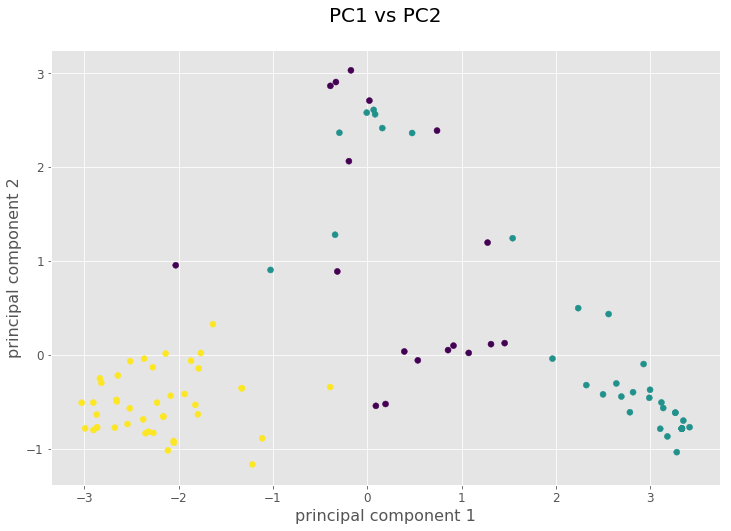

None
Estimated number of clusters: 2
Silhouette Coefficient: 0.233119


 Cluster 0: 
 ['Cuba', 'Poland', 'Hungary', 'Czechoslovakia', 'Albania', 'Yugoslavia', 'Bulgaria', 'Romania', 'Russian Federation', 'Ukraine', 'Belarus', 'Mali', 'Benin', 'Niger', "Côte D'Ivoire", 'Guinea', 'Ghana', 'Togo', 'Nigeria', 'Central African Republic', 'Chad', 'Somalia', 'Ethiopia', 'Madagascar', 'Morocco', 'Libya', 'Sudan', 'Iraq', 'Egypt', 'Israel', 'Saudi Arabia', 'Afghanistan', 'India', 'Myanmar', 'Sri Lanka', 'Nepal', "Lao People's Democratic Republic", 'Indonesia']


 Cluster 1: 
 ['United States of America', 'Canada', 'Haiti', 'Dominican Republic', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Colombia', 'Venezuela, Bolivarian Republic of', 'Ecuador', 'Peru', 'Brazil', 'Bolivia (Plurinational State of)', 'Paraguay', 'Chile', 'Argentina', 'Uruguay', 'United Kingdom of Great Britain and Northern Ireland', 'Netherlands', 'Belgium', 'Luxembourg', 'France', 'Spain', 'Port

In [203]:
# This function forms the basis of the project's finished product and contrains code for prosessing the 
# UN vote DFs and; running through HDBSCAN to create lusters, printing the number of clusters, printing
# a silhouette score, printing a list of countries in each cluster, running the df through PCA analysis, 
# outputting a visualization of clusters based on principle components 1 and 2, and listing the resultions
# which caused the groupings (top 5 contriubuting the most to vaiance)

def output_all(year):
    #HDBSCAN:
    hdbscn = hdbscan.HDBSCAN(min_cluster_size = 10,
               gen_min_span_tree = True)
    hdbscn.fit(frames.get(year))
    hdbscn_labels = hdbscn.labels_
    hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)
    
    df_output_year = create_year_df(year);
    df_output_year['cluster'] = hdbscn.labels_
    df_output_year.reset_index(inplace=True)
    df_output_year = pd.merge(df_output_year, df_name_index, on='ccode')
    
    #Create cluster lists
    cluster0_list = df_output_year[df_output_year.cluster == 0]['Countryname'].tolist()
    cluster1_list = df_output_year[df_output_year.cluster == 1]['Countryname'].tolist()
    cluster2_list = df_output_year[df_output_year.cluster == 2]['Countryname'].tolist()
    cluster_Outlier_list = df_output_year[df_output_year.cluster == -1]['Countryname'].tolist()

    #PCA:
    df_PCA = df_output_year.drop(['Countryname','Country'], axis=1)
    df_features = df_PCA
    X = df_PCA
    X = X.set_index('ccode')
    pca = PCA()
    pca = pca.fit(X)
    Z = pca.transform(X)
    features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
    
    Z = pd.DataFrame(Z, columns=features_pca)
    X.reset_index(inplace=True)
    X = X[['ccode','cluster']]
    
    X = X.join(Z, lsuffix='_caller', rsuffix='_other')
    df_PCA = pd.merge(X, df_PCA, on='ccode')
    df_PCA = df_PCA[['ccode','cluster_x',"PC1","PC2"]] 
    
    # Rolling Out PC1 components:
    PCA_abs = abs((pca.components_))[0]
    df_features = df_features.set_index(['ccode','cluster'])
    t = zip(df_features.columns, PCA_abs)
    result_list = list(t)
    df_componenets = pd.DataFrame(result_list)
    df_componenets.columns = ['rcid', 'score']
    df_componenets = df_componenets.sort_values('score',ascending=False)
    df_componenets['rcid'] = df_componenets['rcid'].map(lambda x: x.lstrip('res__'))
    df_componenets['rcid'] = df_componenets['rcid'].astype(float)
  
    df_componenets = pd.merge(df_componenets, df_descriptions, on='rcid')
    df_pca_desc = df_componenets.descr
    df_componenets = df_componenets.drop(['abstain','yes','no','session','date',
                                          'importantvote','unres','amend',
                                          'para', 'year','Unnamed: 0','descr'], axis=1) #,'me', 'nu','di', 'hr', 'co','ec','short'
    
    pd.set_option('display.max_colwidth',110)
    
    #Plot PCA
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.scatter(Z.iloc[:,0], Z.iloc[:,1],
                       c=df_PCA.cluster_x)
    ax.set_xlabel('principal component 1', fontsize=16)
    ax.set_ylabel('principal component 2', fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    ax.set_title('PC1 vs PC2\n', fontsize=20)
    print(plt.show())
    
    # print HDBSCAN RESULTS:
    print('Estimated number of clusters: %d' % hdbscn_n_clusters_)
    # print('Homogeneity: %0.6f' % metrics.homogeneity_score(frames.get(year), hdbscn_labels))
    # print('Completeness: %0.6f' % metrics.completeness_score(y, hdbscn_labels))
    print('Silhouette Coefficient: %0.6f' % metrics.silhouette_score(frames.get(year), hdbscn_labels))
    
    print ("\n\n","Cluster 0:","\n",cluster0_list)
    print ("\n\n","Cluster 1:","\n",cluster1_list)
    if len(cluster2_list) > 0:
        print ("\n\n","Cluster 2:","\n",cluster2_list)
    else: ""
    
    print ("\n\n","Outliers:","\n",cluster_Outlier_list)
    
    print('\n',df_componenets.head(10))
    print('\n',df_pca_desc.head(10))
    
output_all(1960)  

In [62]:
# When looking at the above output I was able to do this: I noticed that in 1960 a majority of the resolutions
# having the greatest weighting from PCA analysis related to resolution related to the Repulic of the Congo.
# I can see that the clusters there appears to be a a split along traditional cold war lines.  If I googel Congo
# 1960: https://en.wikipedia.org/wiki/Congo_Crisis#United_Nations_escalation_and_the_end_of_the_Katangese_secession
# "Congo Crisis" comes up on the top.  The page says that there "August 1960, Central Intelligence Agency (CIA) 
# agents in the region reported to their agency that "Congo [is] experiencing [a] classic communist ... takeover" 
# and warned that the Congo might follow the same path as Cuba.". So, not perfect, but the results seem useful.

In [63]:
interact(output_all, year=widgets.IntSlider(min=1960,max=2017,step=1,value=10))

A Jupyter Widget

<function __main__.output_all>

# NLP - Topic Modeling

In [161]:
# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.patches as mpatches
import matplotlib
from gensim import corpora, models
import pyLDAvis.gensim

In [162]:
texts = []

In [163]:
df_descriptions.descr = df_descriptions.descr.str.replace('0', "", n=-1)
df_descriptions.descr

0       TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL REFERRING THE PROVISIONAL RULES OF PROCEDURE AND ANY AMENDME...
1       TO ADOPT A USSR PROPOSAL ADJOURNING DEBATE ON AND POSTPONINGELECTIONS OF THE NON-PERMANENT MEMBERS OF THE ...
2       TO ADOPT THE KOREAN PROPOSAL THAT INVALID BALLOTS BE INCLUDED IN THE TOTAL NUMBER OF \MEMBERS PRESENT AND ...
3          TO ADOPT A CUBAN PROPOSAL (A/3-C) THAT AN ITEM ON A DECLARATION OF THE RIGHTS AND DUTIES OF MAN BE TABLED.
4       TO ADOPT A 6TH COMMITTEE AMENDMENT (A/14) TO THE PROVISIONAL RULES OF PROCEDURE, WHICH AMENDMENT PROVIDES ...
5       TO ADOPT A SECOND 6TH COMM. AMENDMENT (A/14) TO THE PROVISIONAL RULES OF PROCEDURE, WHICH AMENDMENT EPLACE...
6       TO OPEN THE DISCUSSION ON THE POLISH DRAFT RESOLUTION (A/22) PROVIDING FOR ECO. & SOC. COUNCIL STUDY AND A...
7       TO ADOPT GENERAL COMM. DRAFT RESOLUTION (A/4) AS AMENDED BY A NORWEGIAN ORAL PROPOSAL (REPLACING \TAKE INT...
8       TO ADOPT DRAFT RESOLUTIONS I AND II AS A WHOLE, 

In [164]:
def text_process(text):

    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    # steming
    porter_stemmer = PorterStemmer()
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    try:
        text_processed.remove('b')
    except: 
        pass
    return text_processed ## <-- one small tweak

In [165]:
for i in range(5601):
    texts.append(text_process(df_descriptions.loc[i, 'descr']))

In [166]:
texts[0:5]

[['adopt',
  'cuban',
  'amend',
  'uk',
  'propos',
  'refer',
  'provision',
  'rule',
  'procedur',
  'amend',
  'thereof',
  '6th',
  'committe',
  'said',
  'amend',
  'prescrib',
  '1',
  'week',
  'time',
  'limit',
  'within',
  '6th',
  'comm',
  'must',
  'submit',
  'report'],
 ['adopt',
  'ussr',
  'propos',
  'adjourn',
  'debat',
  'postponingelect',
  'non',
  'perman',
  'member',
  'secur',
  'council',
  'follow',
  'week'],
 ['adopt',
  'korean',
  'propos',
  'invalid',
  'ballot',
  'includ',
  'total',
  'number',
  'member',
  'present',
  'vote',
  'calcul',
  'major',
  'vote'],
 ['adopt',
  'cuban',
  'propos',
  '3',
  'c',
  'item',
  'declar',
  'right',
  'duti',
  'man',
  'tabl'],
 ['adopt',
  '6th',
  'committe',
  'amend',
  '14',
  'provision',
  'rule',
  'procedur',
  'amend',
  'provid',
  'rule',
  '73',
  'end',
  'shall',
  'nomin']]

In [167]:
# def removeStopWords(str):
#     #select english stopwords
#     cachedStopWords = set(stopwords.words("english"))
#     cachedStopWords.update(('0','1','2','3','4','5','6','7','8','9','and','I','A','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these'))
#     #remove stop words
#     new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
#     return new_str

def text_process(text):
    cachedStopWords = set(stopwords.words("english"))
    
    stopwords = stopwords.words('english')
    stopwords.append('0')

    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords('english')]
    # steming
    porter_stemmer = PorterStemmer()
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    try:
        text_processed.remove('b')
    except: 
        pass
    return text_processed ## <-- one small tweak


In [170]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary,
                                    passes=1,num_topics = 2,minimum_probability=0, random_state=0)

In [171]:
results = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(results)

LinAlgError: Array must not contain infs or NaNs

# Plotting World Map

In [140]:
!pip install pysal
!pip install palettable
!pip install folium

In [141]:
import pysal as ps
from matplotlib.pyplot import *
import statsmodels.api as sm
%matplotlib inline

/Users/jakerattner/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [172]:
shp_link = './ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'  #gadm28.shp
world = ps.pdio.read_files(shp_link)

In [217]:
world.head(100)

,scalerank,featurecla,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,REGION_WB,NAME_LEN,LONG_LEN,ABBREV_LEN,TINY,HOMEPART,MIN_ZOOM,MIN_LABEL,MAX_LABEL,geometry
0,3,Admin-0 country,5.0,Netherlands,NL1,1.0,2.0,Country,Aruba,ABW,...,Latin America & Caribbean,5.0,5.0,5.0,4.0,-99.0,0.0,5.0,10.0,<pysal.cg.shapes.Polygon object at 0x13fdb3fd0>
1,1,Admin-0 country,3.0,Afghanistan,AFG,0.0,2.0,Sovereign country,Afghanistan,AFG,...,South Asia,11.0,11.0,4.0,-99.0,1.0,0.0,3.0,7.0,<pysal.cg.shapes.Polygon object at 0x13fdae080>
2,1,Admin-0 country,3.0,Angola,AGO,0.0,2.0,Sovereign country,Angola,AGO,...,Sub-Saharan Africa,6.0,6.0,4.0,-99.0,1.0,0.0,3.0,7.0,<pysal.cg.shapes.Polygon object at 0x13fdae0f0>
3,1,Admin-0 country,6.0,United Kingdom,GB1,1.0,2.0,Dependency,Anguilla,AIA,...,Latin America & Caribbean,8.0,8.0,4.0,-99.0,-99.0,0.0,5.0,10.0,<pysal.cg.shapes.Polygon object at 0x13fdae0b8>
4,1,Admin-0 country,6.0,Albania,ALB,0.0,2.0,Sovereign country,Albania,ALB,...,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,0.0,5.0,10.0,<pysal.cg.shapes.Polygon object at 0x13fdae208>
5,3,Admin-0 country,6.0,Finland,FI1,1.0,2.0,Country,Aland,ALD,...,Europe & Central Asia,5.0,13.0,5.0,5.0,-99.0,0.0,5.0,10.0,<pysal.cg.shapes.Polygon object at 0x13fdae278>
6,3,Admin-0 country,6.0,Andorra,AND,0.0,2.0,Sovereign country,Andorra,AND,...,Europe & Central Asia,7.0,7.0,4.0,5.0,1.0,0.0,5.0,10.0,<pysal.cg.shapes.Polygon object at 0x13fdae240>
7,1,Admin-0 country,4.0,United Arab Emirates,ARE,0.0,2.0,Sovereign country,United Arab Emirates,ARE,...,Middle East & North Africa,20.0,20.0,6.0,-99.0,1.0,0.0,4.0,9.0,<pysal.cg.shapes.Polygon object at 0x13fdae390>
8,1,Admin-0 country,2.0,Argentina,ARG,0.0,2.0,Sovereign country,Argentina,ARG,...,Latin America & Caribbean,9.0,9.0,4.0,-99.0,1.0,0.0,2.0,7.0,<pysal.cg.shapes.Polygon object at 0x13fdae3c8>
9,1,Admin-0 country,6.0,Armenia,ARM,0.0,2.0,Sovereign country,Armenia,ARM,...,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,0.0,5.0,10.0,<pysal.cg.shapes.Polygon object at 0x13fdae400>


In [175]:
from pysal.contrib.viz import mapping as viz

In [226]:

world[world.SOVEREIGNT =='Germany']

,scalerank,featurecla,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,REGION_WB,NAME_LEN,LONG_LEN,ABBREV_LEN,TINY,HOMEPART,MIN_ZOOM,MIN_LABEL,MAX_LABEL,geometry
57,1,Admin-0 country,2.0,Germany,DEU,0.0,2.0,Sovereign country,Germany,DEU,...,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,0.0,1.7,6.7,<pysal.cg.shapes.Polygon object at 0x13a0d8438>


In [225]:
df_votes[df_votes.Country=='DDR']

,rcid,ccode,session,member,vote,Country,Countryname,year
288653,1412.0,265,28.0,1.0,2,DDR,German Democratic Republic,1973
288850,1413.0,265,28.0,1.0,1,DDR,German Democratic Republic,1973
289047,1414.0,265,28.0,1.0,2,DDR,German Democratic Republic,1973
289244,1415.0,265,28.0,1.0,2,DDR,German Democratic Republic,1973
289441,1416.0,265,28.0,1.0,2,DDR,German Democratic Republic,1973
289638,1417.0,265,28.0,1.0,1,DDR,German Democratic Republic,1973
289835,1418.0,265,28.0,1.0,2,DDR,German Democratic Republic,1973
290032,1419.0,265,28.0,1.0,2,DDR,German Democratic Republic,1973
290229,1420.0,265,28.0,1.0,1,DDR,German Democratic Republic,1973
290426,1421.0,265,28.0,1.0,1,DDR,German Democratic Republic,1973


In [178]:
world.SOV_A3.unique()

array(['NL1', 'AFG', 'AGO', 'GB1', 'ALB', 'FI1', 'AND', 'ARE', 'ARG',
       'ARM', 'US1', 'ATA', 'AU1', 'FR1', 'ATG', 'AUT', 'AZE', 'BDI',
       'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR',
       'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN',
       'CHE', 'CHL', 'CH1', 'CIV', 'CMR', 'COD', 'COG', 'NZ1', 'COL',
       'COM', 'CPV', 'CRI', 'CUB', 'CYN', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DN1', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST',
       'ETH', 'FJI', 'FSM', 'GAB', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB',
       'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN',
       'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'IS1', 'ITA', 'JAM',
       'JOR', 'JPN', 'KAS', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA',
       'KOR', 'KOS', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE',
       'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MCO', 'MDA', 'MDG',
       'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG',
       'MOZ', 'MRT',

In [179]:
df_votes.Country.unique()

array(['USA', 'CAN', 'CUB', 'HTI', 'DOM', 'MEX', 'GTM', 'HND', 'SLV',
       'NIC', 'CRI', 'PAN', 'COL', 'VEN', 'ECU', 'PER', 'BRA', 'BOL',
       'PRY', 'CHL', 'ARG', 'URY', 'GBR', 'NLD', 'BEL', 'LUX', 'FRA',
       'POL', 'CSK', 'YUG', 'GRC', 'RUS', 'UKR', 'BLR', 'SWE', 'NOR',
       'DNK', 'ISL', 'LBR', 'ETH', 'ZAF', 'IRN', 'TUR', 'IRQ', 'EGY',
       'SYR', 'LBN', 'SAU', 'AFG', 'TWN', 'IND', 'THA', 'PHL', 'AUS',
       'NZL', nan, 'PAK', 'ISR', 'MMR', 'IDN', 'IRL', 'ESP', 'PRT', 'AUT',
       'HUN', 'ITA', 'ALB', 'BGR', 'ROU', 'FIN', 'LBY', 'JOR', 'LKA',
       'NPL', 'KHM', 'LAO', 'GHA', 'MAR', 'TUN', 'SDN', 'JPN', 'MYS',
       'GIN', 'CYP', 'MLI', 'SEN', 'BEN', 'NER', 'CIV', 'BFA', 'TGO',
       'CMR', 'NGA', 'GAB', 'CAF', 'TCD', 'COG', 'COD', 'SOM', 'MDG',
       'MRT', 'SLE', 'TZA', 'MNG', 'JAM', 'TTO', 'UGA', 'BDI', 'RWA',
       'DZA', 'KEN', 'EAZ', 'KWT', 'MLT', 'ZMB', 'MWI', 'GMB', 'MDV',
       'SGP', 'BRB', 'GUY', 'LSO', 'BWA', 'MUS', 'YMD', 'GNQ', 'SWZ',
       'FJI', '

In [180]:
    hdbscn = hdbscan.HDBSCAN(min_cluster_size = 10,
               gen_min_span_tree = True)
    hdbscn.fit(frames.get(1960))
    hdbscn_labels = hdbscn.labels_
    hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)
    
    df_output_year = create_year_df(1960);
    df_output_year['cluster'] = hdbscn.labels_
    df_output_year.reset_index(inplace=True)
    df_output_year = pd.merge(df_output_year, df_name_index, on='ccode')
    df_output_year = df_output_year[['cluster','Country']].sort_values('Country')
    df_output_year.head()

,cluster,Country
82,0,AFG
35,0,ALB
20,1,ARG
96,1,AUS
31,1,AUT


In [192]:
df_output_year.cluster = df_output_year.cluster.replace(to_replace=3, value=, inplace=False, limit=None, regex=False, method='pad', axis=None)

In [193]:
df_output_year.cluster = df_output_year.cluster.replace(to_replace=2, value=, inplace=False, limit=None, regex=False, method='pad', axis=None)

In [194]:
df_output_year.cluster = df_output_year.cluster.replace(to_replace=1, value=, inplace=False, limit=None, regex=False, method='pad', axis=None)

In [195]:
df_output_year.cluster = df_output_year.cluster.replace(to_replace=0, value=, inplace=False, limit=None, regex=False, method='pad', axis=None)

In [209]:
df_output_year[df_output_year.Country =='USA']

#df_output_year[(df_output_year.Country == 1) | (df_votes_year.vote == 3)]

,cluster,Country
0,3,USA


In [210]:
df_output_year.to_csv('map_data.csv', index=False)

/Users/jakerattner/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1308: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= b] = i
/Users/jakerattner/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1312: RuntimeWarning: invalid value encountered in less
  iret[xx < self.vmin] = -1
/Users/jakerattner/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1313: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= self.vmax] = max_col


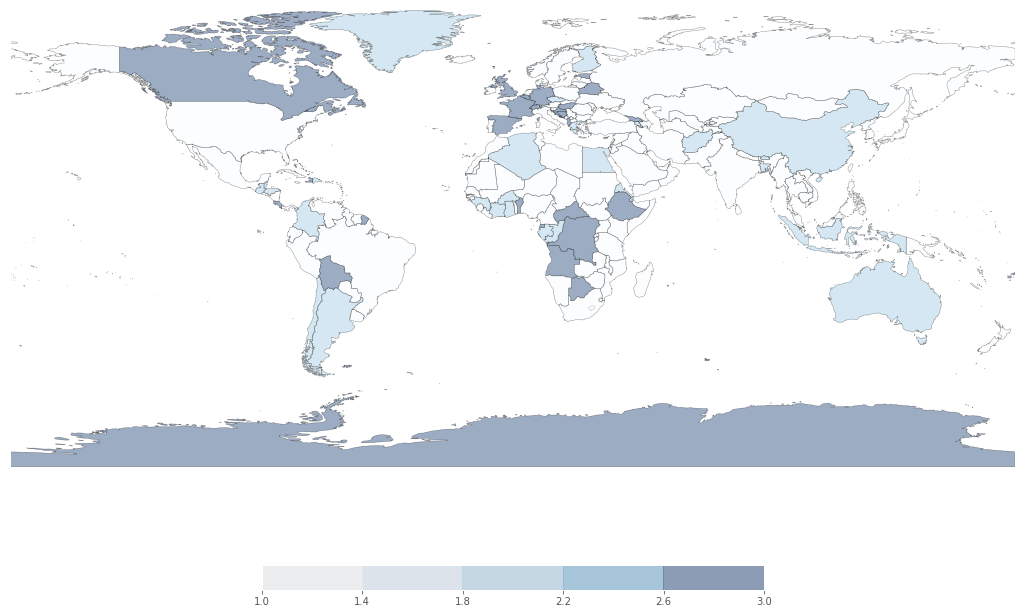

In [211]:
viz.plot_choropleth(shp_link, values = np.array(ps.open('./map_data.csv').by_col('cluster')), type = 'equal_interval',cmap = 'Blues',figsize=(18, 12))

/Users/jakerattner/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


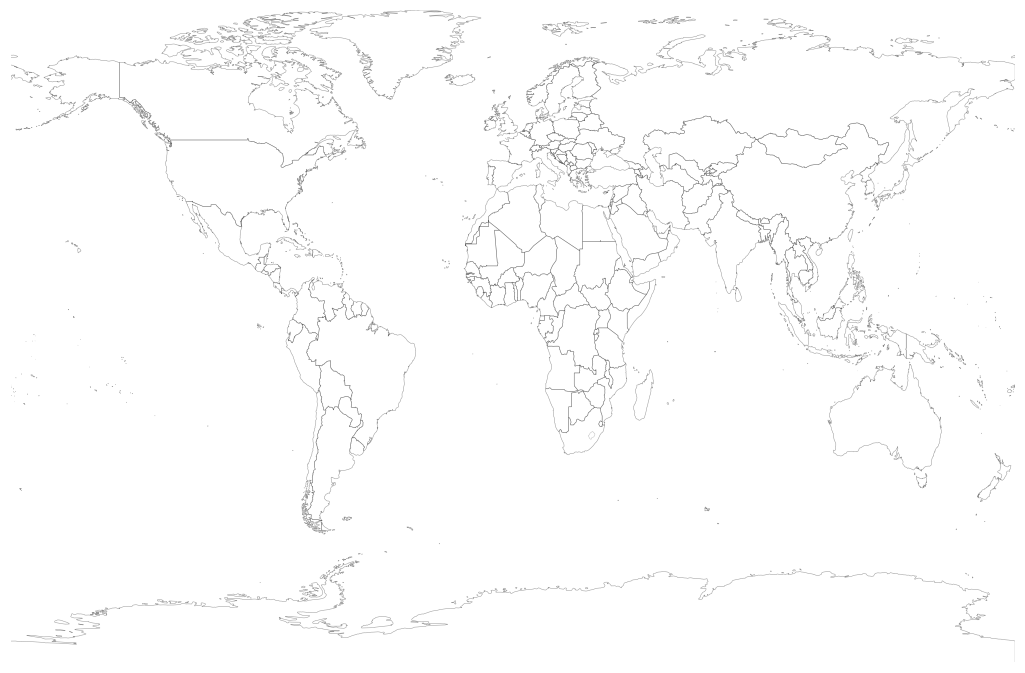

In [212]:
viz.plot_choropleth(shp_link, values = np.array(ps.open('./map_data.csv').by_col('cluster')), type = 'classless',figsize=(18, 12))

# Write Up

## How you acquired your data (including any sampling that you did)
 - The data comes from the UN API portal here: http://data.un.org/Host.aspx?Content=API
 - The specific data set I'm using is organized by Erik Voeten from Harvard Univerity an is available here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/12379
 - I'm using a shape file of UN regions. These data were extracted from the GADM database (www.gadm.org)
 - I'm hoping to, but have not yet used from here: http://data.un.org/Data.aspx?q=aid+datamart%5bWDI%5d&d=WDI&f=Indicator_Code%3aDT.ODA.ALLD.CD
    
## How the data should be transformed, including justifying your choices
- I take out all non-member countries from the data
- I change th codeing of yes and no votes to 1 and 0
- I drop all other vote types (abstain, absentee, etc)
- I'm breaking out the data into individual data frames for each year that the UN was in session
- For PCA the datasframes for each year are joined with a dataset of resolution descriptions 
- For LDA the descriptions are tokenized, lemmetized and regular English stopwords are removed

## How you operationalized your outcome variable, including your justification
- Sadly I do not know what this is, so in all likelihood I didn't optimze any outcome cariables
    
## Your choice of model and any hyperparameters, including what metric or metrics you use to determine a successful model

Models: 

HDBSCAN: I tried K-means and DBSCAN as well, but HDBSCAN worked best in terms of both performance (measure by silhoutte score) and in that it automtically selected the number of  clusters.  I chose a minimum cluster size of 10.  Some years still create errors, but this was the size that created the most consistent clustering over the period the data was collected (1948 - 2017).  The model was found to be successful when it repeatedly produced clusters consistent with historical literature and created a low number of errors when applied to each year.

Priciple Component Analysis (really feature selection/visualization):

This serves two purposes in this project.  

First, it allows the clusters to be visualized in 2D.  Once the model was constructed it proved successful right away.  It shows the size and the arrangement of the yearly clustering.  There are some limitations to the visualization however.  You can see closeness in the clusters, but its difficult to inturpret this.  It also doesn't show the geographic layout.  At the moment I'm not able to show which country in the visualization is which.

Second, I'm using the PCA analysis to find which resolutions were weighted most heavily.  In other words which resolutions contributed the most variance and therfore would have the greatest effect on clusters in a given year.  This was possible because virtually all the variance was placed on component 1 once the analysis was run.


NLP Topic Mapping:
Topic mapping is used (hypethetically, not currently working) in order to create categories for each resolution.  This serves the purpose of showing which kind of resultions affect clustering in a given year.
    
## Any future deployment strategies, additions of data, or modeling techniques you have yet to try

There's a quite a few useful strategies and techniques that can be employed in the future
- Include abstaining votes in the model (weighted by a factor based on liturature review)
- Create Topics based on topic modeling
- Use topics to better understand clustering around certain issues
- Rerun models based on specific topic areas, and possibly run clusters over 5-year periods to see long term and topic based trends
- Visualize clusters geographically by placing them on a world map
